<a href="https://colab.research.google.com/github/alimertgok/Stock-Price-Prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STOCK PRICE PREDICTION with LSTM MODULE

## Data preprocessing




### Import Libraries

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Filepath

In [ ]:
# Load the file
filepath = '/content/drive/MyDrive/GOOGL_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(filepath)
df = df.sort_values('Date')
df = df[['Date', 'Close']]  # We are only interested in the 'Close' price for prediction
df.head()

,Date,Close
0,2006-01-03,217.83
1,2006-01-04,222.84
2,2006-01-05,225.85
3,2006-01-06,233.06
4,2006-01-09,233.68


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Close   3019 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.3+ KB


### Checking null values

In [ ]:
# prompt: Using dataframe df: checking null values
df.isnull().sum()

Date     0
Close    0
dtype: int64

### Visualization

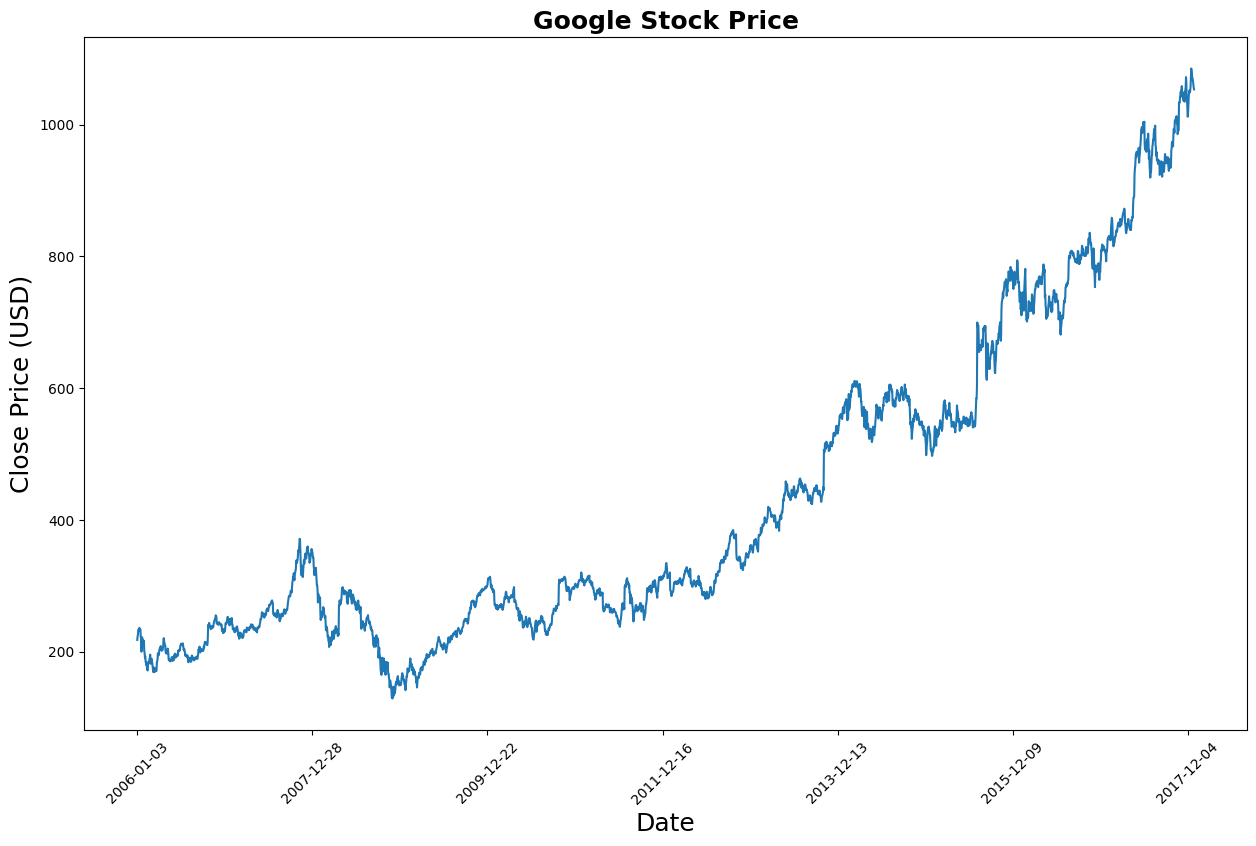

In [ ]:
plt.figure(figsize = (15,9))
plt.plot(df[['Close']])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title("Google Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

## Normalize data

In [ ]:
price = df[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

# purpose: learn more effectively by having all input features within the same range

<ipython-input-37-77e3f41ac3d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


### Splitting the data into train and test sets

In [ ]:
def split_train_test(stock, lookback):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []

    # to increase the speed of training
    # create all possible sequences of length lookback
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    # Split data into X and y
    X = data[:, :-1] # selects all rows and all columns except the last one.
    y = data[:, -1] # selects all rows but only the last column.

    # Create train/test split
    train_split = int(0.8 * len(data))  # 80% of data used for training set, 20% for testing
    X_train, y_train = X[:train_split], y[:train_split]
    X_test, y_test = X[train_split:], y[train_split:]

    return [X_train, y_train, X_test, y_test]


In [ ]:
lookback = 60 # days (approximately 2 months) is often a good starting point.
X_train, y_train, X_test, y_test = split_train_test(price, lookback)
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2367, 59, 1)
y_train.shape =  (2367, 1)
x_test.shape =  (592, 59, 1)
y_test.shape =  (592, 1)


### Convert them into tensors

In [ ]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## Building the LSTM Model

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

## Training the Model
The idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

In other words: poor representation -> better representation.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

* **Optimizer:** Takes into account the loss of a model and adjust the model's parameters (e.g. weight & bias)to improve the loss function.

And specifically for Pytorch, we need:
* A training loop
* a testing loop

### Creating a loss function and optimizer in PyTorch

In [ ]:
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training and testing loop

1) Forward pass (this involves data moving through our model's forward() functions) to make predictions on data- also called forward propagation

2) Calculate the loss (compare forward predictions to ground truth labels)

3) Zero gradients

4) Perform backpropagation on the loss - move backwards through the network to calculate the gradients of each of the paramaters of our model with respect to the loss

5) Update the optimizer (gradient descent) - improve the loss

In [ ]:
loss_values=[]
epoch_count=[]
test_loss_values=[]

start_time = time.time()

### Training
# 0. loop through the data
for epoch in range(num_epochs):
  # set the model to training mode (this is the default state of model)
  model.train()

  # 1. forward pass
  y_pred = model(X_train) # PASS THE DATA THROUGH THE MODEL, THIS WILL PERFORM THE `forward()` METHOD LOCATED WITHIN THE MODEL OBJECT

  # 2. calculate the loss (how different are model's predictions to the true values)
  loss = loss_function(y_pred, y_train)

  # 3. zero the gradients
  optimizer.zero_grad() #  ACCUMULATE EVERY EPOCH, ZERO TO START FRESH FORWARD PASS

  # 4. perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. step the optimizer (perform gradient descent)
  optimizer.step()


  ### Testing
  model.eval() # turns off gradient tracking or in other words turns off different settings in the model not needed for evualation
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # Do the forward pass
    y_test_pred = model(X_test)

    # Calculate loss
    y_test_loss = loss_function(y_test_pred, y_test)


  # Print out what's happening
  if epoch % 10 == 0:  # Print the loss every 10 epochs
    epoch_count.append(epoch)
    test_loss_values.append(y_test_loss.item())
    loss_values.append(loss.item())
    print(f"Epoch: {epoch} | Training Loss (MSE): {loss.item()} | Test Loss: {y_test_loss.item()}")

training_time = time.time()-start_time
print("Training time: {} seconds".format(training_time))


Epoch: 0 | Training Loss (MSE): 0.0012199021875858307 | Test Loss: 0.19206605851650238
Epoch: 10 | Training Loss (MSE): 0.0011697133304551244 | Test Loss: 0.18761709332466125
Epoch: 20 | Training Loss (MSE): 0.0011240022722631693 | Test Loss: 0.18338999152183533
Epoch: 30 | Training Loss (MSE): 0.0010821438627317548 | Test Loss: 0.17931953072547913
Epoch: 40 | Training Loss (MSE): 0.0010436692973598838 | Test Loss: 0.17535948753356934
Epoch: 50 | Training Loss (MSE): 0.0010082157095894217 | Test Loss: 0.17157326638698578
Epoch: 60 | Training Loss (MSE): 0.0009755133651196957 | Test Loss: 0.16796721518039703
Epoch: 70 | Training Loss (MSE): 0.0009453821694478393 | Test Loss: 0.16451312601566315
Epoch: 80 | Training Loss (MSE): 0.0009177227620966733 | Test Loss: 0.16120579838752747
Epoch: 90 | Training Loss (MSE): 0.0008925015572458506 | Test Loss: 0.15802432596683502
Training time: 116.39309501647949 seconds


### Denormalize the data

In [ ]:
# Denormalize the training data predictions and actual values
predict_train = pd.DataFrame(scaler.inverse_transform(y_pred.detach().numpy())) # y_train_pred
original_train = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

# Denormalize the test data predictions and actual values
predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy())) # denormalize test predictions
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().numpy())) # denormalize original test data

# Adjust indices for test predictions and original test data to follow training data
predict_test.index = predict_test.index + len(predict_train)
original_test.index = original_test.index + len(original_train) # This ensures that the test predictions follow the training predictions sequentially on the x-axis.

### Plotting

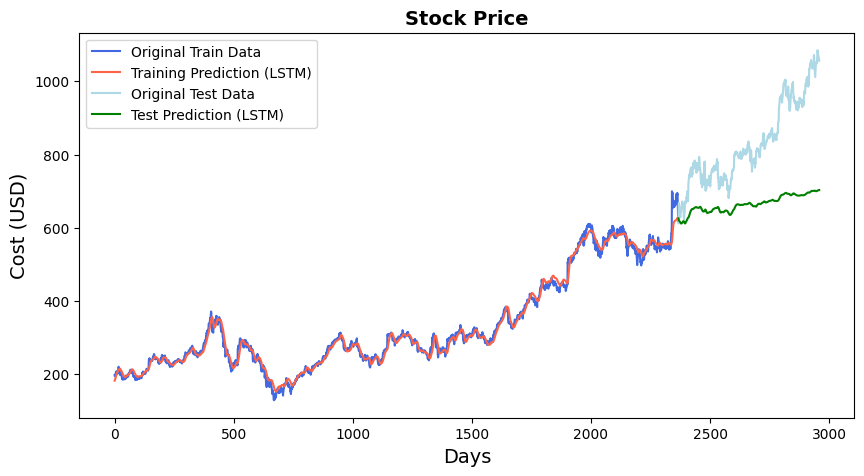

In [ ]:
# Plotting the stock prices
plt.figure(figsize=(10, 5))

# Plotting the original training data
plt.plot(original_train.index, original_train[0], label="Original Train Data", color='royalblue')

# Plotting the training predictions
plt.plot(predict_train.index, predict_train[0], label="Training Prediction (LSTM)", color='tomato')

# Plotting the original test data
plt.plot(original_test.index, original_test[0], label="Original Test Data", color='lightblue')

# Plotting the test predictions (continuing from training predictions)
plt.plot(predict_test.index, predict_test[0], label="Test Prediction (LSTM)", color='green')

plt.title('Stock Price', fontsize=14, fontweight='bold')
plt.xlabel("Days", fontsize=14)
plt.ylabel("Cost (USD)", fontsize=14)
plt.legend()
plt.show()

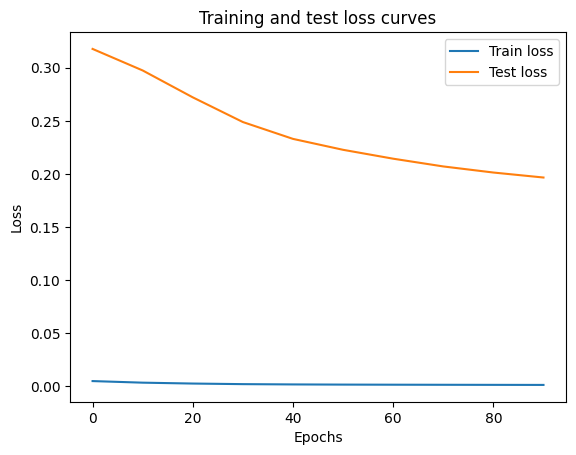

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
np.shape(y_pred)

torch.Size([2367, 1])